<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span></li><li><span><a href="#Process-Data" data-toc-modified-id="Process-Data-2">Process Data</a></span></li><li><span><a href="#Exploration" data-toc-modified-id="Exploration-3">Exploration</a></span></li><li><span><a href="#Fitting-the-Model---Linear-Regression---Full-Model" data-toc-modified-id="Fitting-the-Model---Linear-Regression---Full-Model-4">Fitting the Model - Linear Regression - Full Model</a></span></li><li><span><a href="#Fitting-the-Model---Linear-Regression---Subset" data-toc-modified-id="Fitting-the-Model---Linear-Regression---Subset-5">Fitting the Model - Linear Regression - Subset</a></span></li><li><span><a href="#Fitting-the-Model---Random-Forest" data-toc-modified-id="Fitting-the-Model---Random-Forest-6">Fitting the Model - Random Forest</a></span></li><li><span><a href="#Projecting-Feature-Values---Exponential-Smoothing" data-toc-modified-id="Projecting-Feature-Values---Exponential-Smoothing-7">Projecting Feature Values - Exponential Smoothing</a></span></li><li><span><a href="#Generate-Predicted-Response-Using-Projections" data-toc-modified-id="Generate-Predicted-Response-Using-Projections-8">Generate Predicted Response Using Projections</a></span></li><li><span><a href="#Further-Exploration" data-toc-modified-id="Further-Exploration-9">Further Exploration</a></span></li></ul></div>

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Load data
filename = "input/prediction_input.tab"  # Replace with public-access S3 bucket later
raw_data = pd.read_csv(filename, sep="\t", dtype={"fips": "str"})

In [3]:
raw_data.head()

,fips,county,population,tot_male,tot_female,wa,ba,ia,aa,h,...,year,year_min,year_max,pct_hs_diploma,pct_bachelors,pov_pct,median_hh_inc,unemploy_rate,deaths,deaths_age_adj
0,01001,"Autauga County, AL",43900.0,21333.0,22567.0,35584.0,7572.0,210.0,205.0,610.0,...,2000,2000,2005,33.8,18.0,10.9,42013.0,4.0,0.0,0.0
1,01001,"Autauga County, AL",54754.0,26670.0,28084.0,43409.0,9743.0,250.0,497.0,1308.0,...,2010,2006,2011,85.0,21.8,10.3,51463.0,9.7,1.0,1.0
2,01001,"Autauga County, AL",55443.0,27017.0,28426.0,42568.0,10828.0,259.0,698.0,1584.0,...,2017,2012,2017,33.6,25.0,13.7,55317.0,3.9,1.0,1.0
3,01003,"Baldwin County, AL",141404.0,69337.0,72067.0,124134.0,14663.0,834.0,551.0,2512.0,...,2000,2000,2005,29.6,23.1,10.1,40250.0,3.7,44,5.2
4,01003,"Baldwin County, AL",183111.0,89618.0,93493.0,160470.0,17334.0,1330.0,1384.0,8064.0,...,2010,2006,2011,87.5,26.6,11.9,48918.0,9.8,71,7.2


In [4]:
raw_data.shape

(9441, 25)

# Process Data

In [5]:
data = raw_data.copy()
data = data.replace("Missing", np.nan).replace("Unreliable", np.nan)
data.dropna(inplace=True)

In [6]:
# Convert columns to float
data = data.astype({"deaths": "float64", "deaths_age_adj": "float64", "population": "float64"})
data.dtypes

fips               object
county             object
population        float64
tot_male          float64
tot_female        float64
wa                float64
ba                float64
ia                float64
aa                float64
h                 float64
age_grp_4         float64
age_grp_5         float64
age_grp_6         float64
age_grp_7         float64
age_grp_8         float64
year                int64
year_min            int64
year_max            int64
pct_hs_diploma    float64
pct_bachelors     float64
pov_pct           float64
median_hh_inc     float64
unemploy_rate     float64
deaths            float64
deaths_age_adj    float64
dtype: object

In [7]:
# Generate percentage variables
vars_to_convert = {
    "tot_male": "pct_male",
    "tot_female": "pct_female",
    "wa": "pct_white",
    "ba": "pct_black",
    "ia": "pct_aina",  # American Indian/Alaskan Native
    "aa": "pct_apia",  # Asian/Pacific Islander
    "h": "pct_hispanic",
    "age_grp_4": "pct_15_19",
    "age_grp_5": "pct_20_24",
    "age_grp_6": "pct_25_29",
    "age_grp_7": "pct_30_34",
    "age_grp_8": "pct_35_39"
}

for old_var, new_var in vars_to_convert.items():
    data[new_var] = data[old_var] / data["population"]

# Add a grouped age bucket for 20-29 (research indicates vulnerability to opioid addiction)
data["age_25_39"] = data["age_grp_6"] + data["age_grp_7"] + data["age_grp_8"]
data["pct_25_39"] = data["age_25_39"] / data["population"]

In [8]:
# Convert existing percentages to actual percentages
vars_to_scale = ["pct_hs_diploma", "pct_bachelors", "pov_pct", "unemploy_rate"]
for var in vars_to_scale:
    data[var] = data[var] / 100.0

# Convert deaths to mean death rate (over 6 years), calculated as deaths per 100,000 (CDC methodology)
# https://www-doh.state.nj.us/doh-shad/view/sharedstatic/CrudeDeathRate.pdf
data["mean_deaths"] = data["deaths"] / 6
data["death_rate"] = data["mean_deaths"] / data["population"] * 100000

In [9]:
# Drop old count columns
data.drop(["tot_male", "tot_female", "wa", "ba", "ia", "aa", "h",
           "age_grp_4", "age_grp_5", "age_grp_6", "age_grp_7", "age_grp_8", "age_25_39"], axis=1, inplace=True)

In [10]:
data.columns

Index(['fips', 'county', 'population', 'year', 'year_min', 'year_max',
       'pct_hs_diploma', 'pct_bachelors', 'pov_pct', 'median_hh_inc',
       'unemploy_rate', 'deaths', 'deaths_age_adj', 'pct_male', 'pct_female',
       'pct_white', 'pct_black', 'pct_aina', 'pct_apia', 'pct_hispanic',
       'pct_15_19', 'pct_20_24', 'pct_25_29', 'pct_30_34', 'pct_35_39',
       'pct_25_39', 'mean_deaths', 'death_rate'],
      dtype='object')

In [11]:
data.shape

(8115, 28)

# Exploration

In [12]:
data.loc[0, :]

fips                           01001
county            Autauga County, AL
population                     43900
year                            2000
year_min                        2000
year_max                        2005
pct_hs_diploma                 0.338
pct_bachelors                   0.18
pov_pct                        0.109
median_hh_inc                  42013
unemploy_rate                   0.04
deaths                             0
deaths_age_adj                     0
pct_male                    0.485945
pct_female                  0.514055
pct_white                   0.810569
pct_black                   0.172483
pct_aina                   0.0047836
pct_apia                   0.0046697
pct_hispanic               0.0138952
pct_15_19                  0.0743052
pct_20_24                  0.0541913
pct_25_29                   0.061344
pct_30_34                  0.0692483
pct_35_39                  0.0910023
pct_25_39                   0.221595
mean_deaths                        0
d

In [13]:
# sbn.pairplot(data.iloc[:, pd.np.r_[-2, 2, 18:23]])

In [14]:
# sbn.pairplot(data.iloc[:, pd.np.r_[-2, 24:31]])

In [15]:
# sbn.pairplot(data.iloc[:, pd.np.r_[-2, 31:38, 41]])

In [16]:
# Get list of variables
for i, x in enumerate(data.columns):
    print(i, x)

0 fips
1 county
2 population
3 year
4 year_min
5 year_max
6 pct_hs_diploma
7 pct_bachelors
8 pov_pct
9 median_hh_inc
10 unemploy_rate
11 deaths
12 deaths_age_adj
13 pct_male
14 pct_female
15 pct_white
16 pct_black
17 pct_aina
18 pct_apia
19 pct_hispanic
20 pct_15_19
21 pct_20_24
22 pct_25_29
23 pct_30_34
24 pct_35_39
25 pct_25_39
26 mean_deaths
27 death_rate


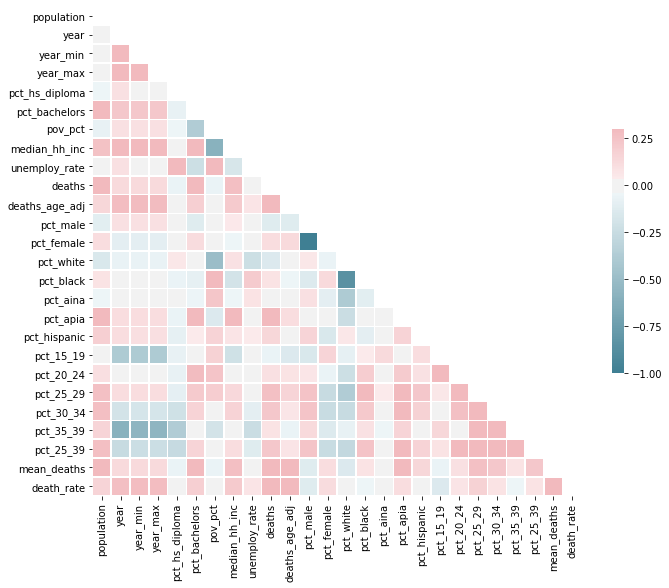

In [17]:
corr = data.iloc[:, :].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
cmap = sbn.diverging_palette(220, 10, as_cmap=True)

sbn.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

In [18]:
corr.to_csv("correlation.csv")

# Fitting the Model - Linear Regression - Full Model

In [19]:
response_var = "death_rate"  # Change to "deaths_age_adj" for prediction of age-adjusted rate

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Remove non-feature columns
non_feature_columns = ["fips", "county", "year", "year_min", "year_max",
                       "mean_deaths", "death_rate", "deaths", "deaths_age_adj"]
features = [col for col in data.columns.tolist() if col not in non_feature_columns]
X = data[features]
y = data[response_var]
X.columns

Index(['population', 'pct_hs_diploma', 'pct_bachelors', 'pov_pct',
       'median_hh_inc', 'unemploy_rate', 'pct_male', 'pct_female', 'pct_white',
       'pct_black', 'pct_aina', 'pct_apia', 'pct_hispanic', 'pct_15_19',
       'pct_20_24', 'pct_25_29', 'pct_30_34', 'pct_35_39', 'pct_25_39'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=503)

In [23]:
linreg_full = LinearRegression()
linreg_full.fit(X_train, y_train)
print("R^2: {0}".format(linreg_full.score(X_train, y_train)))

predictions = linreg_full.predict(X_test)
rmse = np.sqrt(np.sum((predictions - y_test)**2)/y_test.shape[0])
print("RMSE: {0}".format(rmse))

R^2: 0.21687506797437642
RMSE: 5.489126586451944


# Fitting the Model - Linear Regression - Subset

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=503)

In [26]:
# Model with only a subset of features
feature_subset = ['population', 'pct_male', 'pct_white', 'pct_25_39', 'pct_hs_diploma', 'median_hh_inc',
                  'pov_pct', 'unemploy_rate']

X_train = X_train[feature_subset]
X_test = X_test[feature_subset]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
print("R^2: {0}".format(linreg.score(X_train, y_train)))

predictions = linreg.predict(X_test)
rmse = np.sqrt(np.sum((predictions - y_test)**2)/y_test.shape[0])
print("RMSE: {0}".format(rmse))

R^2: 0.1506482613226222
RMSE: 5.742060547680173


$RMSE = \sqrt{\sum{\frac{(\hat{y} - y)^2}{N}}}$

# Fitting the Model - Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
# Pick a subset of columns to feed into random forest
non_feature_columns = ["fips", "county", "year", "year_min", "year_max",
                       "mean_deaths", "death_rate", "deaths", "deaths_age_adj"]
features = [col for col in data.columns.tolist() if col not in non_feature_columns]
X = data[features]
y = data[response_var]
X.columns

Index(['population', 'pct_hs_diploma', 'pct_bachelors', 'pov_pct',
       'median_hh_inc', 'unemploy_rate', 'pct_male', 'pct_female', 'pct_white',
       'pct_black', 'pct_aina', 'pct_apia', 'pct_hispanic', 'pct_15_19',
       'pct_20_24', 'pct_25_29', 'pct_30_34', 'pct_35_39', 'pct_25_39'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=503)
rf = RandomForestRegressor(random_state=503,
                           min_samples_split=2,
                           min_samples_leaf=4,
                           max_features="sqrt",
                           n_estimators=400,
                           bootstrap=True)
rf.fit(X_train, y_train)
print("R^2: {0}".format(rf.score(X_train, y_train)))


predictions = rf.predict(X_test)
rmse = np.sqrt(np.sum((predictions - y_test)**2)/y_test.shape[0])
print("RMSE: {0}".format(rmse))

R^2: 0.7772193519269417
RMSE: 4.143406948366568


It appears the random forest has a better RMSE, so we'll use that model.

In [30]:
rf.feature_importances_

array([0.22527567, 0.03895513, 0.04315283, 0.0533086 , 0.04047159,
       0.03842341, 0.02690858, 0.0271115 , 0.03561945, 0.05074377,
       0.0544743 , 0.0555982 , 0.05150489, 0.08182141, 0.03196601,
       0.03531099, 0.02945962, 0.04878022, 0.03111382])

In [31]:
print(np.argsort(rf.feature_importances_)[::-1])

[ 0 13 11 10  3 12  9 17  2  4  1  5  8 15 14 18 16  7  6]


In [32]:
# Get list of variables
for i, x in enumerate(X.columns):
    print(i, x)

0 population
1 pct_hs_diploma
2 pct_bachelors
3 pov_pct
4 median_hh_inc
5 unemploy_rate
6 pct_male
7 pct_female
8 pct_white
9 pct_black
10 pct_aina
11 pct_apia
12 pct_hispanic
13 pct_15_19
14 pct_20_24
15 pct_25_29
16 pct_30_34
17 pct_35_39
18 pct_25_39


# Projecting Feature Values - Exponential Smoothing

Because we're rolling up multiple years, we ignore any seasonality effects.

We also do not have sufficient data for each county to forecast using ARIMA. We will use exponential smoothing.

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas import datetime

In [34]:
def year_parser(x):
    """Helper function to convert year into a datetime for use in ExponentialSmoothing."""
    return datetime.strptime(x, '%Y')

In [35]:
import warnings
warnings.filterwarnings('ignore')

fips_codes = data['fips'].unique()

projections = {}

for fips in fips_codes:
    # Go through each county's subset of data
    subset = data.loc[data['fips'] == fips].sort_values('year')
    projections[fips] = []
    
    for feature in features:
#         print("Trying {0}/{1}".format(fips, feature))
        # Iterate through each feature to make an exponential smoothing-based projection        
        series = subset[feature]
        series = series.astype(np.float)  # Convert the variable to a float
        
        try:
            es = ExponentialSmoothing(series, trend='mul')  # multiplicative trend        
            es_fit = es.fit()            
            projection = es_fit.predict(start=3, end=3)[3]
        
            projections[fips].append(projection)  # Build the projected values for each FIPS code
        except ValueError:
            # Not enough data to apply exponential smoothing, or value doesn't fit model requirements
            # Just use latest value in this case
            last_year = subset.sort_values('year', ascending=False).iloc[0, :]  # Sort descending by year
            projection = subset[feature].astype(np.float).values[0]
            
            projections[fips].append(projection)

In [36]:
projections_df = pd.DataFrame.from_dict(projections, orient='index', columns=features)
projections_df.index.name = 'fips'
projections_df.head()

,population,pct_hs_diploma,pct_bachelors,pov_pct,median_hh_inc,unemploy_rate,pct_male,pct_female,pct_white,pct_black,pct_aina,pct_apia,pct_hispanic,pct_15_19,pct_20_24,pct_25_29,pct_30_34,pct_35_39,pct_25_39
fips,,,,,,,,,,,,,,,,,,,
01001,62487.964061,0.644137,0.295754,0.147686,62166.775404,0.072046,0.487918,0.512084,0.748550,0.206216,0.004578,0.018596,0.038495,0.068270,0.062426,0.067192,0.059383,0.054199,0.181153
01003,263646.905709,0.535423,0.353974,0.128629,58822.367963,0.066271,0.483323,0.516731,0.869766,0.085722,0.008811,0.016818,0.072883,0.056710,0.052273,0.058251,0.051667,0.050856,0.159653
01005,24883.773201,0.558758,0.127999,0.270294,38463.558396,0.093185,0.532725,0.467631,0.481001,0.489340,0.007124,0.005494,0.072078,0.049061,0.058967,0.073174,0.067842,0.053770,0.193800
01007,28876.169435,0.663828,0.456252,0.082744,82827.947327,0.030371,0.626951,0.393227,0.715840,0.247735,0.010182,0.014178,0.162634,0.039984,0.056895,0.092026,0.064890,0.056171,0.209154
01009,61459.435726,0.499458,0.150640,0.172490,54568.089228,0.069289,0.488832,0.511263,0.952298,0.018806,0.006705,0.003933,0.119539,0.063731,0.053697,0.058199,0.049858,0.052717,0.158397


# Generate Predicted Response Using Projections

In [37]:
prediction_col_name = "predicted_" + response_var
projections_df[prediction_col_name] = rf.predict(projections_df)
projections_df.head()

,population,pct_hs_diploma,pct_bachelors,pov_pct,median_hh_inc,unemploy_rate,pct_male,pct_female,pct_white,pct_black,pct_aina,pct_apia,pct_hispanic,pct_15_19,pct_20_24,pct_25_29,pct_30_34,pct_35_39,pct_25_39,predicted_death_rate
fips,,,,,,,,,,,,,,,,,,,,
01001,62487.964061,0.644137,0.295754,0.147686,62166.775404,0.072046,0.487918,0.512084,0.748550,0.206216,0.004578,0.018596,0.038495,0.068270,0.062426,0.067192,0.059383,0.054199,0.181153,8.063258
01003,263646.905709,0.535423,0.353974,0.128629,58822.367963,0.066271,0.483323,0.516731,0.869766,0.085722,0.008811,0.016818,0.072883,0.056710,0.052273,0.058251,0.051667,0.050856,0.159653,11.383112
01005,24883.773201,0.558758,0.127999,0.270294,38463.558396,0.093185,0.532725,0.467631,0.481001,0.489340,0.007124,0.005494,0.072078,0.049061,0.058967,0.073174,0.067842,0.053770,0.193800,3.003223
01007,28876.169435,0.663828,0.456252,0.082744,82827.947327,0.030371,0.626951,0.393227,0.715840,0.247735,0.010182,0.014178,0.162634,0.039984,0.056895,0.092026,0.064890,0.056171,0.209154,5.218468
01009,61459.435726,0.499458,0.150640,0.172490,54568.089228,0.069289,0.488832,0.511263,0.952298,0.018806,0.006705,0.003933,0.119539,0.063731,0.053697,0.058199,0.049858,0.052717,0.158397,11.270102


In [38]:
projections_df.to_csv(prediction_col_name + ".csv")

# Further Exploration

In [39]:
data.loc[data['fips'] == '01001'].loc[:, ['year', response_var]]

,year,death_rate
0,2000,0.000000
1,2010,0.304392
2,2017,0.300609
